# Fashion Classification (DeepFashion Dataset) - Refactored

In [21]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import PIL

from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset
from torch.autograd import Variable
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from matplotlib import pyplot as plt
from random import randint

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# load images

root_dir = 'img/'

target_size = (256, 256)
transforms = Compose([
    Resize(target_size),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

images = ImageFolder(root_dir, transform=transforms)

In [4]:
print(images)

Dataset ImageFolder
    Number of datapoints: 289219
    Root Location: img/
    Transforms (if any): Compose(
                             Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [7]:
list_category_img = pd.read_csv('list_category_img.txt', sep="\t", header=0)
list_category_img.columns = ["image_name", "category_label"]

list_category_cloth = pd.read_csv('list_category_cloth.txt', sep="\t", header=0)
list_category_cloth.columns = ["category_name", "category_type"]

list_eval_partition = pd.read_csv('list_eval_partition.txt', sep="\t", header=0)
list_eval_partition.columns = ["image_name", "evaluation_status"]

In [8]:
list_category_img.head()

,image_name,category_label
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [9]:
list_category_cloth.head()

,category_name,category_type
0,Anorak,1
1,Blazer,1
2,Blouse,1
3,Bomber,1
4,Button-Down,1


In [10]:
list_eval_partition.head()

,image_name,evaluation_status
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


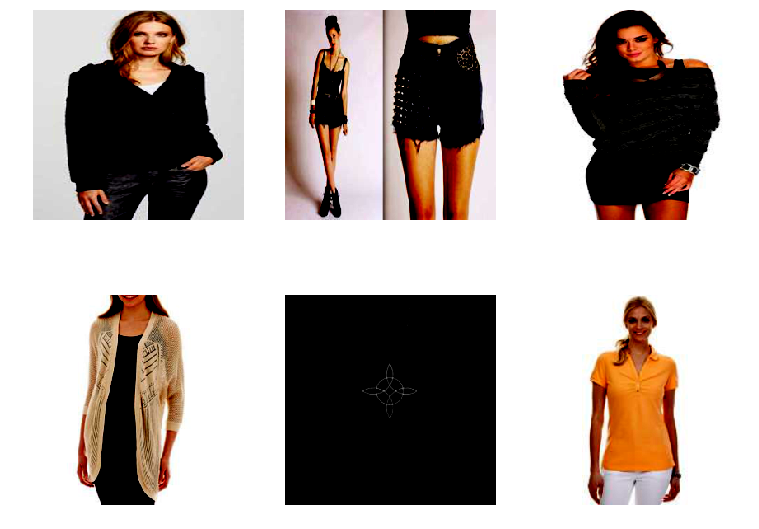

In [11]:
f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(images))
    axes[i].imshow(images[index][0].permute(1, 2, 0))
    axes[i].axis('off')

## Data preparation

In [164]:
class DeepFashionDataset(Dataset):

    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        datapoint = self.data[index][0]
        target = self.target[index]
       
        return datapoint, target

In [165]:
train_indices = list_eval_partition[list_eval_partition.evaluation_status == 'train'].index
train_images = Subset(images, train_indices)
train_labels = list_category_img.category_label[train_indices].values

val_indices = list_eval_partition[list_eval_partition.evaluation_status == 'val'].index
val_images = Subset(images, val_indices)
val_labels = list_category_img.category_label[val_indices].values

test_indices = list_eval_partition[list_eval_partition.evaluation_status == 'test'].index
test_images = Subset(images, test_indices)
test_labels = list_category_img.category_label[test_indices].values

In [166]:
train_set = DeepFashionDataset(train_images, train_labels)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

val_set = DeepFashionDataset(val_images, val_labels)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

test_set = DeepFashionDataset(test_images, test_labels)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [169]:
image, label = train_set[124939]
print(image.size())
print(label)

torch.Size([3, 256, 256])
33


In [170]:
#We can iterate over the dataset
for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys)
    break

torch.Size([64, 3, 256, 256]) torch.Size([64])
tensor([41,  3, 16, 41, 17, 19, 18, 18, 18, 19, 42, 24, 32, 41,  2, 10, 41, 48,
        18, 41, 48, 18, 33, 16,  2, 41, 18, 26, 18, 41, 18, 41,  3,  3, 16,  3,
        41, 39, 41, 18, 30, 30, 41, 12, 16, 18, 18, 41, 33, 41, 11,  3, 41,  6,
        18, 42, 16, 18, 33,  2, 41, 16, 11, 17])


In [172]:
nbr_of_classes = len(list_category_cloth)

In [ ]:
def train(model, loss_fn, optimizer, scheduler, num_epochs, trainloader, valloader):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataloader = None
    dataset_size = 0
    
    for epoch in range(num_epochs):
        since = time.time()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
                dataloader = trainloader
                dataset_size = len(trainloader.dataset)
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valloader
                dataset_size = len(valloader.dataset)
             
            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            
            for data in dataloader:
                # get the inputs
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = loss_fn(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).to(torch.float32)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model